In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras import utils as np_utils
# Chargement des données MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Prétraitement : Passage en vecteur (784) et normalisation [0, 1]
X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test = X_test.reshape(10000, 784).astype('float32') / 255

# Encodage One-Hot des labels
K = 10
Y_train = np_utils.to_categorical(y_train, K)
Y_test = np_utils.to_categorical(y_test, K)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


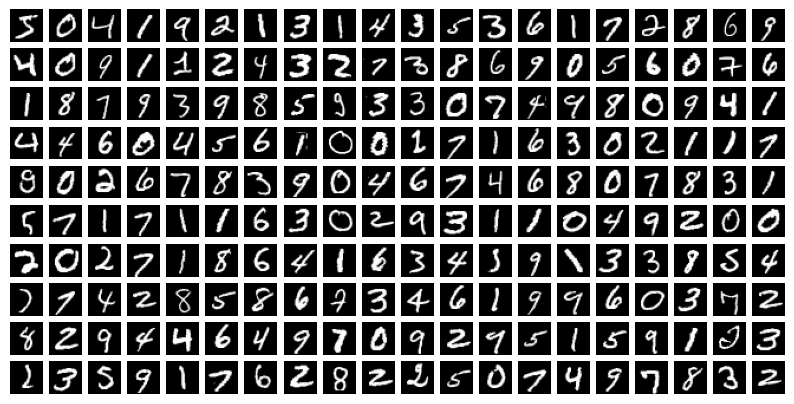

In [3]:
plt.figure(figsize=(10, 5), dpi=100)
for i in range(200):
    plt.subplot(10, 20, i+1)
    plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# Analyse de la dimensionnalité
nombre_images, dimension_totale = X_train.shape
cote_image = int(np.sqrt(dimension_totale))

print(f"Nombre d'images : {nombre_images}")
print(f"Taille d'un vecteur image : {dimension_totale}")
print(f"Format original de l'image : {cote_image}x{cote_image} pixels")

# Vérification des valeurs extrêmes
print(f"Valeur pixel min : {X_train.min()}")
print(f"Valeur pixel max : {X_train.max()}")

Nombre d'images : 60000
Taille d'un vecteur image : 784
Format original de l'image : 28x28 pixels
Valeur pixel min : 0.0
Valeur pixel max : 1.0


In [5]:
def softmax(X):
    # Calcul stable du softmax
    E = np.exp(X - np.max(X, axis=1, keepdims=True)) 
    return (E.T / np.sum(E, axis=1)).T

def forward_logreg(batch, W, b):
    # Projection linéaire + Softmax
    return softmax(np.dot(batch, W) + b)

def accuracy(W, b, images, labels):
    pred = forward_logreg(images, W, b)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean() * 100.0

In [10]:
# --- Sous-partie : Nombre de paramètres ---
D_in = X_train.shape[1]  # 784
K_out = 10               # Classes

# Initialisation symbolique pour le calcul
W_shape = (D_in, K_out)
b_shape = (1, K_out)

nb_poids = W_shape[0] * W_shape[1]
nb_biais = b_shape[1]
total_params = nb_poids + nb_biais

print(f"Analyse des paramètres du modèle :")
print(f" - Matrice de poids W : {W_shape[0]} entrées x {W_shape[1]} sorties = {nb_poids} paramètres")
print(f" - Vecteur de biais b : {nb_biais} paramètres")
print(f" - Nombre total de paramètres ajustables : {total_params}")

Analyse des paramètres du modèle :
 - Matrice de poids W : 784 entrées x 10 sorties = 7840 paramètres
 - Vecteur de biais b : 10 paramètres
 - Nombre total de paramètres ajustables : 7850


In [11]:
# --- Sous-partie : État initial et Coût (Entropy Croisée) ---
# Simulation d'un forward pass sur le premier batch avant apprentissage
W_init = np.zeros((D_in, K_out))
b_init = np.zeros((1, K_out))

# On prend les 100 premières images
batch_test = X_train[:100]
labels_test = Y_train[:100]

# Forward pass initial
s_init = np.dot(batch_test, W_init) + b_init
y_pred_init = softmax(s_init)

# Calcul du coût initial (Entropie croisée moyenne)
# À l'initialisation (0), softmax donne 1/K pour chaque classe
cout_initial = -np.mean(np.sum(labels_test * np.log(y_pred_init + 1e-9), axis=1))

print(f"Analyse pré-optimisation :")
print(f" - Valeur du coût initial (poids à zéro) : {cout_initial:.4f}")
print(f" - Probabilité prédite pour chaque classe : {y_pred_init[0,0]:.2f} (soit 1/{K_out})")
print(f" - Le modèle est dans un état d'incertitude maximale, prêt pour la descente de gradient.")

Analyse pré-optimisation :
 - Valeur du coût initial (poids à zéro) : 2.3026
 - Probabilité prédite pour chaque classe : 0.10 (soit 1/10)
 - Le modèle est dans un état d'incertitude maximale, prêt pour la descente de gradient.


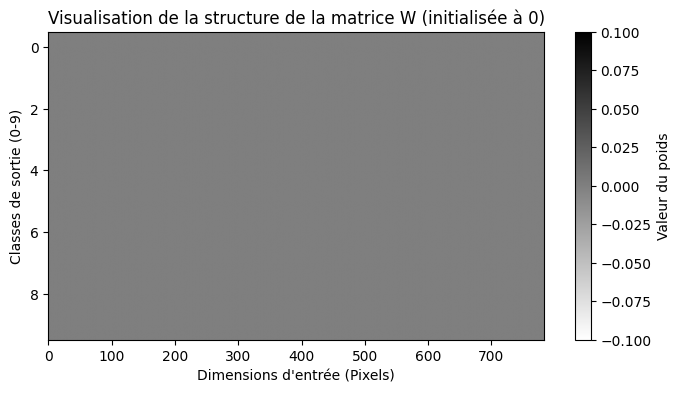

In [12]:
# --- Sous-partie : Structure des données ---
plt.figure(figsize=(8, 4))
plt.title("Visualisation de la structure de la matrice W (initialisée à 0)")
plt.imshow(W_init.T, aspect='auto', cmap='binary')
plt.xlabel("Dimensions d'entrée (Pixels)")
plt.ylabel("Classes de sortie (0-9)")
plt.colorbar(label="Valeur du poids")
plt.show()

Résultats après 20 époques :
 - Pas de gradient 0.1  -> Accuracy Test: 92.47%
 - Pas de gradient 0.01 -> Accuracy Test: 91.95%


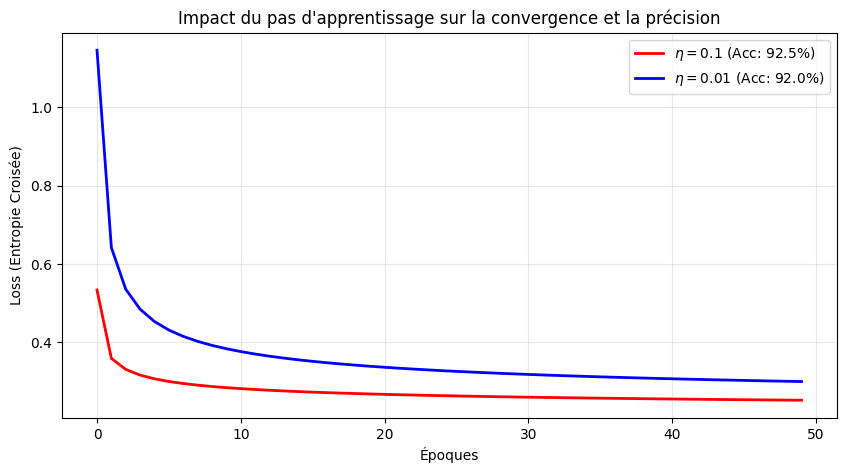

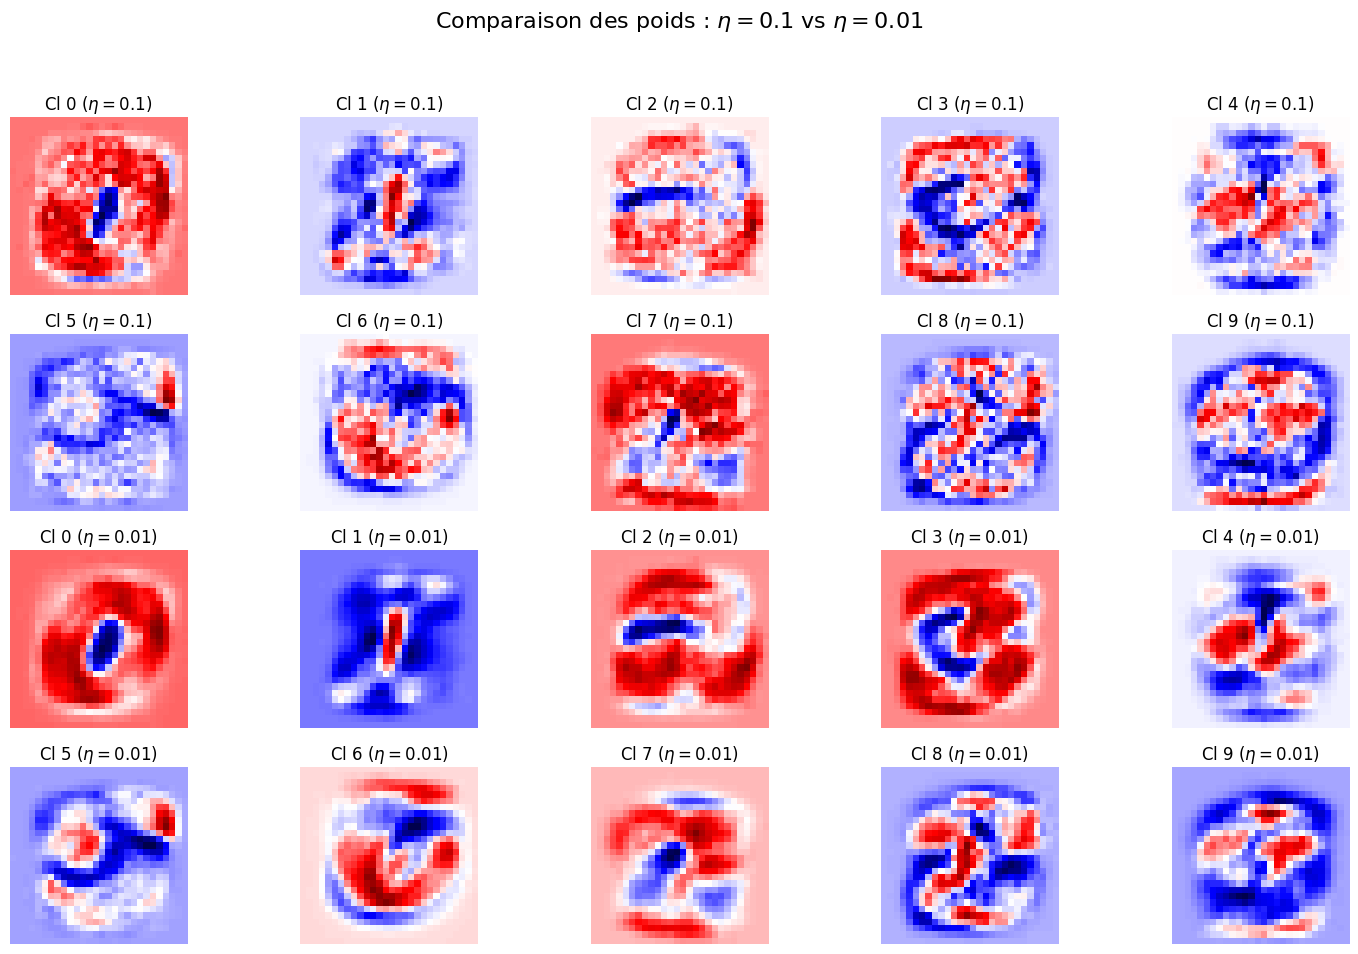

In [18]:
def train_and_get_results(eta_value, num_epochs=50):
    """Entraîne le modèle et retourne les poids, l'historique de loss et l'accuracy finale."""
    N, d = X_train.shape
    W = np.zeros((d, K))
    b = np.zeros((1, K))
    batch_size = 100
    nb_batches = int(N / batch_size)
    history_loss = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(nb_batches):
            batch_X = X_train[i*batch_size : (i+1)*batch_size]
            batch_Y = Y_train[i*batch_size : (i+1)*batch_size]
            
            # FORWARD
            Y_hat = forward_logreg(batch_X, W, b)
            # Ajout d'un epsilon pour la stabilité numérique du log
            loss = -np.mean(np.sum(batch_Y * np.log(Y_hat + 1e-9), axis=1))
            epoch_loss += loss
            
            # BACKWARD
            delta_y = Y_hat - batch_Y
            gradW = np.dot(batch_X.T, delta_y) / batch_size
            gradb = np.mean(delta_y, axis=0)
            
            # MISE À JOUR
            W -= eta_value * gradW
            b -= eta_value * gradb
            
        history_loss.append(epoch_loss / nb_batches)
    
    # Calcul de l'accuracy finale sur le jeu de test
    final_acc = accuracy(W, b, X_test, Y_test)
    return W, history_loss, final_acc

# --- Exécution pour les deux valeurs de pas ---
W_01, loss_01, acc_01 = train_and_get_results(eta_value=0.1)
W_001, loss_001, acc_001 = train_and_get_results(eta_value=0.01)

# --- Affichage des performances finales ---
print(f"Résultats après {20} époques :")
print(f" - Pas de gradient 0.1  -> Accuracy Test: {acc_01:.2f}%")
print(f" - Pas de gradient 0.01 -> Accuracy Test: {acc_001:.2f}%")

# --- Figure 1 : Comparaison des courbes de convergence ---
plt.figure(figsize=(10, 5))
plt.plot(loss_01, label=f'$\eta = 0.1$ (Acc: {acc_01:.1f}%)', color='red', lw=2)
plt.plot(loss_001, label=f'$\eta = 0.01$ (Acc: {acc_001:.1f}%)', color='blue', lw=2)
plt.title("Impact du pas d'apprentissage sur la convergence et la précision")
plt.xlabel("Époques")
plt.ylabel("Loss (Entropie Croisée)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Figure 2 : Comparaison visuelle des poids ---
def comparer_visuels(W1, W2, label1, label2):
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    plt.suptitle(f"Comparaison des poids : {label1} vs {label2}", fontsize=16)
    
    for i in range(10):
        # Ligne du haut (W1)
        ax = axes[i//5, i%5]
        ax.imshow(W1[:, i].reshape(28, 28), cmap='seismic')
        ax.set_title(f"Cl {i} ({label1})")
        ax.axis('off')
        
        # Ligne du bas (W2)
        ax = axes[(i//5)+2, i%5]
        ax.imshow(W2[:, i].reshape(28, 28), cmap='seismic')
        ax.set_title(f"Cl {i} ({label2})")
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

comparer_visuels(W_01, W_001, "$\eta=0.1$", "$\eta=0.01$")

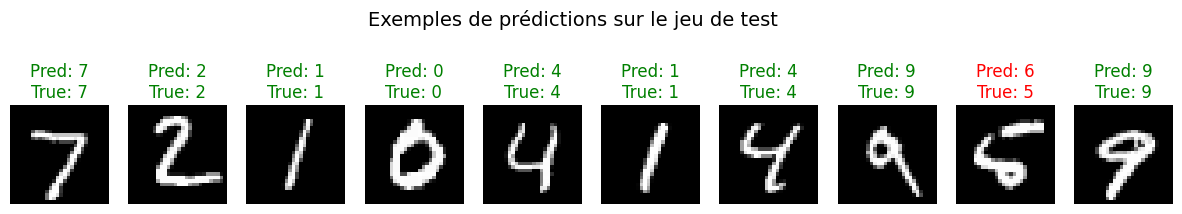

In [19]:
def visualiser_predictions(W, b, images, labels, n_images=10):
    # Calcul des prédictions pour les n premières images de test
    preds = forward_logreg(images[:n_images], W, b)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels[:n_images], axis=1)

    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        
        # Titre en vert si correct, rouge si erreur
        color = 'green' if pred_labels[i] == true_labels[i] else 'red'
        plt.title(f"Pred: {pred_labels[i]}\nTrue: {true_labels[i]}", color=color)
        plt.axis('off')
    plt.suptitle("Exemples de prédictions sur le jeu de test", fontsize=14)
    plt.show()

# Utilisation des poids entraînés avec eta=0.1
visualiser_predictions(W_01, b, X_test, Y_test)

In [20]:
def sigmoid(x):
    # Fonction d'activation pour la couche cachée
    return 1 / (1 + np.exp(-x))

def forward_mlp(batch, Wh, bh, Wy, by):
    # 1. Projection vers la couche cachée
    u = np.dot(batch, Wh) + bh
    # 2. Activation non linéaire (Sigmoïde)
    h = sigmoid(u)
    # 3. Projection vers la couche de sortie
    v = np.dot(h, Wy) + by
    # 4. Activation Softmax
    y_hat = softmax(v)
    return y_hat, h

def accuracy_mlp(Wh, bh, Wy, by, images, labels):
    pred, _ = forward_mlp(images, Wh, bh, Wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean() * 100.0

In [21]:
def train_mlp(init_type="xavier", eta=1.0, numEp=100):
    N, d = X_train.shape
    L = 100 # Nombre de neurones cachés
    K = 10  # Nombre de classes
    batch_size = 100
    nb_batches = int(N / batch_size)

    # --- INITIALISATION ---
    if init_type == "zeros":
        Wh = np.zeros((d, L))
        bh = np.zeros((1, L))
        Wy = np.zeros((L, K))
        by = np.zeros((1, K))
    elif init_type == "normal":
        sigma = 0.1
        Wh = np.random.randn(d, L) * sigma
        bh = np.zeros((1, L))
        Wy = np.random.randn(L, K) * sigma
        by = np.zeros((1, K))
    elif init_type == "xavier":
        Wh = np.random.randn(d, L) / np.sqrt(d)
        bh = np.zeros((1, L))
        Wy = np.random.randn(L, K) / np.sqrt(L)
        by = np.zeros((1, K))

    history_loss = []
    
    # --- BOUCLE D'APPRENTISSAGE ---
    for epoch in range(numEp):
        for i in range(nb_batches):
            batch_X = X_train[i*batch_size : (i+1)*batch_size]
            batch_Y = Y_train[i*batch_size : (i+1)*batch_size]
            
            # 1. FORWARD
            Y_hat, H = forward_mlp(batch_X, Wh, bh, Wy, by)
            
            # 2. BACKWARD
            # Erreur en sortie (delta_y)
            delta_y = Y_hat - batch_Y
            
            # Gradients couche de sortie (Wy, by)
            gradWy = np.dot(H.T, delta_y) / batch_size
            gradby = np.mean(delta_y, axis=0)
            
            # Rétro-propagation vers la couche cachée (delta_h)
            # Formule : delta_y * Wy.T * derivée_sigmoide
            delta_h = np.dot(delta_y, Wy.T) * (H * (1 - H))
            
            # Gradients couche cachée (Wh, bh)
            gradWh = np.dot(batch_X.T, delta_h) / batch_size
            gradbh = np.mean(delta_h, axis=0)
            
            # 3. MISE À JOUR
            Wy -= eta * gradWy
            by -= eta * gradby
            Wh -= eta * gradWh
            bh -= eta * gradbh
            
        if (epoch + 1) % 10 == 0:
            acc = accuracy_mlp(Wh, bh, Wy, by, X_test, Y_test)
            print(f"Époque {epoch+1}/{numEp} - Accuracy Test: {acc:.2f}%")
            
    return Wh, bh, Wy, by

In [25]:
# Test avec initialisation à zéro
print("--- Test : Initialisation à Zéro ---")
Wh_0, bh_0, Wy_0, by_0 = train_mlp(init_type="zeros", eta=1.0, numEp=100)
acc_0 = accuracy_mlp(Wh_0, bh_0, Wy_0, by_0, X_test, Y_test)
print(f"Précision finale (Zeros): {acc_0:.2f}%")

--- Test : Initialisation à Zéro ---
Époque 10/100 - Accuracy Test: 63.26%
Époque 20/100 - Accuracy Test: 64.41%
Époque 30/100 - Accuracy Test: 64.13%
Époque 40/100 - Accuracy Test: 64.46%
Époque 50/100 - Accuracy Test: 64.53%
Époque 60/100 - Accuracy Test: 64.46%
Époque 70/100 - Accuracy Test: 64.29%
Époque 80/100 - Accuracy Test: 64.10%
Époque 90/100 - Accuracy Test: 64.05%
Époque 100/100 - Accuracy Test: 63.96%
Précision finale (Zeros): 63.96%


In [26]:
# Test avec initialisation Loi Normale
print("\n--- Test : Initialisation Normale (sigma=0.1) ---")
Wh_n, bh_n, Wy_n, by_n = train_mlp(init_type="normal", eta=1.0, numEp=100)
acc_n = accuracy_mlp(Wh_n, bh_n, Wy_n, by_n, X_test, Y_test)
print(f"Précision finale (Normale): {acc_n:.2f}%")


--- Test : Initialisation Normale (sigma=0.1) ---
Époque 10/100 - Accuracy Test: 97.39%
Époque 20/100 - Accuracy Test: 97.60%
Époque 30/100 - Accuracy Test: 97.73%
Époque 40/100 - Accuracy Test: 97.70%
Époque 50/100 - Accuracy Test: 97.71%
Époque 60/100 - Accuracy Test: 97.75%
Époque 70/100 - Accuracy Test: 97.79%
Époque 80/100 - Accuracy Test: 97.81%
Époque 90/100 - Accuracy Test: 97.82%
Époque 100/100 - Accuracy Test: 97.84%
Précision finale (Normale): 97.84%


In [24]:
# Test avec initialisation de Xavier
print("\n--- Test : Initialisation de Xavier ---")
Wh_x, bh_x, Wy_x, by_x = train_mlp(init_type="xavier", eta=1.0, numEp=100)
acc_x = accuracy_mlp(Wh_x, bh_x, Wy_x, by_x, X_test, Y_test)
print(f"Précision finale (Xavier): {acc_x:.2f}%")


--- Test : Initialisation de Xavier ---
Époque 10/100 - Accuracy Test: 97.45%
Époque 20/100 - Accuracy Test: 97.79%
Époque 30/100 - Accuracy Test: 97.80%
Époque 40/100 - Accuracy Test: 97.90%
Époque 50/100 - Accuracy Test: 97.97%
Époque 60/100 - Accuracy Test: 98.01%
Époque 70/100 - Accuracy Test: 98.01%
Époque 80/100 - Accuracy Test: 98.04%
Époque 90/100 - Accuracy Test: 98.07%
Époque 100/100 - Accuracy Test: 98.07%
Précision finale (Xavier): 98.07%
